# Convolutional Neural Network 모델 정의

In [ ]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"#"mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cpu


In [ ]:
layer = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3)#, stride=1, padding=0)
print(layer)

Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1))


In [ ]:
# layer객체.weight,  layer객체.bias  => layer의 weight, bias를 조회
layer.weight.shape
# [2, 4, 3, 3] -> [out_channels=>필터의개수, in_channels, height, width]

torch.Size([2, 4, 3, 3])

In [ ]:
layer.bias.shape

torch.Size([2])

In [ ]:
input_data = torch.ones(1, 4, 3, 3) #데이터개수: 1, ch:4, h:3, w:3,

In [ ]:
# 채널별로 연산
ch1 = torch.sum(input_data[0, 0] * layer.weight[0, 0])
ch2 = torch.sum(input_data[0, 1] * layer.weight[0, 1])
ch3 = torch.sum(input_data[0, 2] * layer.weight[0, 2])
ch4 = torch.sum(input_data[0, 3] * layer.weight[0, 3])
# 채널별 합계 + bias
result = ch1 + ch2 + ch3 + ch4 + layer.bias[0].item()
result

tensor(0.8283, grad_fn=<AddBackward0>)

In [ ]:
ch1 = torch.sum(input_data[0, 0] * layer.weight[1, 0])
ch2 = torch.sum(input_data[0, 1] * layer.weight[1, 1])
ch3 = torch.sum(input_data[0, 2] * layer.weight[1, 2])
ch4 = torch.sum(input_data[0, 3] * layer.weight[1, 3])
# 채널별 합계 + bias
result2 = ch1 + ch2 + ch3 + ch4 + layer.bias[1].item()
result2

tensor(0.1092, grad_fn=<AddBackward0>)

In [ ]:
result3 = layer(input_data)
result3

tensor([[[[0.8283]],

         [[0.1092]]]], grad_fn=<ConvolutionBackward0>)

# MNIST

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn
# import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchinfo import summary
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.train import fit

import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

cuda


## Data 준비

In [9]:
DATASET_ROOT_PATH = 'datasets'
MODEL_SAVE_PATH = 'models'

import os
os.makedirs(DATASET_ROOT_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

N_EPOCH = 20
BATCH_SIZE = 128
LR = 0.001

In [10]:
train_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, True)
test_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, False)

In [5]:
train_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
test_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## CNN 모델 정의

In [11]:
# CNN - Conv layer: fiter의 개수(out_channels)는 뒤로 갈수록 크게잡는다.
#                   출력결과(Feature map) 의  size(height, width)는 줄여나간다. => MaxPool
# Conv block:
#   1. Conv + ReLU + MaxPooling
#   2. Conv + Batch Norm + ReLU + MaxPooling
#   3. Conv + Batch Norm + ReLU + Dropout + MaxPooling
class FMnistCNNModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            # 3x3 필터, stride=1, padding=1 => input size == output size
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),# 노멀라이즈
            nn.ReLU(), # 비선형
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # kernel_size 와 stride가 동일할 경우 stride는 생략가능
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),# 노멀라이즈
            nn.ReLU(), # 비선형
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),# 노멀라이즈
            nn.ReLU(), # 비선형
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=2)
        )
        self.output_block = nn.Sequential(
            nn.Linear(128*3*3, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 10)
        )

    def forward(self, X):
        out = self.block1(X)
        out = self.block2(out)
        out = self.block3(out)   #특성 추출
        out = nn.Flatten()(out)
        out = self.output_block(out)  # 추론
        return out

In [12]:
model = FMnistCNNModel().to(device)
summary(model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FMnistCNNModel                           [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─Dropout2d: 2-4                    [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-5                    [128, 32, 14, 14]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-6                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-7                  [128, 64, 14, 14]         128
│    └─ReLU: 2-8                         [128, 64, 14, 14]         --
│    └─Dropout2d: 2-9                    [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-10                   [128, 64, 7, 7]           --
├─Sequent

In [13]:
fit?

In [14]:
# 학습
save_path = os.path.join(MODEL_SAVE_PATH, "fmnist_cnn_model.pt")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

result = fit(train_loader, test_loader, model, loss_fn, optimizer, N_EPOCH,
            save_best_model=True, save_model_path=save_path,
            early_stopping=True, device=device,
            mode='multi')

Epoch[1/20] - Train loss: 0.36328 Train Accucracy: 0.86457 || Validation Loss: 0.38732 Validation Accuracy: 0.85890
저장: 1 - 이전 : inf, 현재: 0.3873197879595093
Epoch[2/20] - Train loss: 0.29135 Train Accucracy: 0.88920 || Validation Loss: 0.32853 Validation Accuracy: 0.87680
저장: 2 - 이전 : 0.3873197879595093, 현재: 0.3285294788170464
Epoch[3/20] - Train loss: 0.24211 Train Accucracy: 0.91018 || Validation Loss: 0.28393 Validation Accuracy: 0.89660
저장: 3 - 이전 : 0.3285294788170464, 현재: 0.28392514378964145
Epoch[4/20] - Train loss: 0.23033 Train Accucracy: 0.91272 || Validation Loss: 0.27498 Validation Accuracy: 0.89760
저장: 4 - 이전 : 0.28392514378964145, 현재: 0.2749752476811409
Epoch[5/20] - Train loss: 0.20393 Train Accucracy: 0.92348 || Validation Loss: 0.25211 Validation Accuracy: 0.90660
저장: 5 - 이전 : 0.2749752476811409, 현재: 0.2521121874451637
Epoch[6/20] - Train loss: 0.19420 Train Accucracy: 0.92775 || Validation Loss: 0.24962 Validation Accuracy: 0.90930
저장: 6 - 이전 : 0.2521121874451637, 현재: 

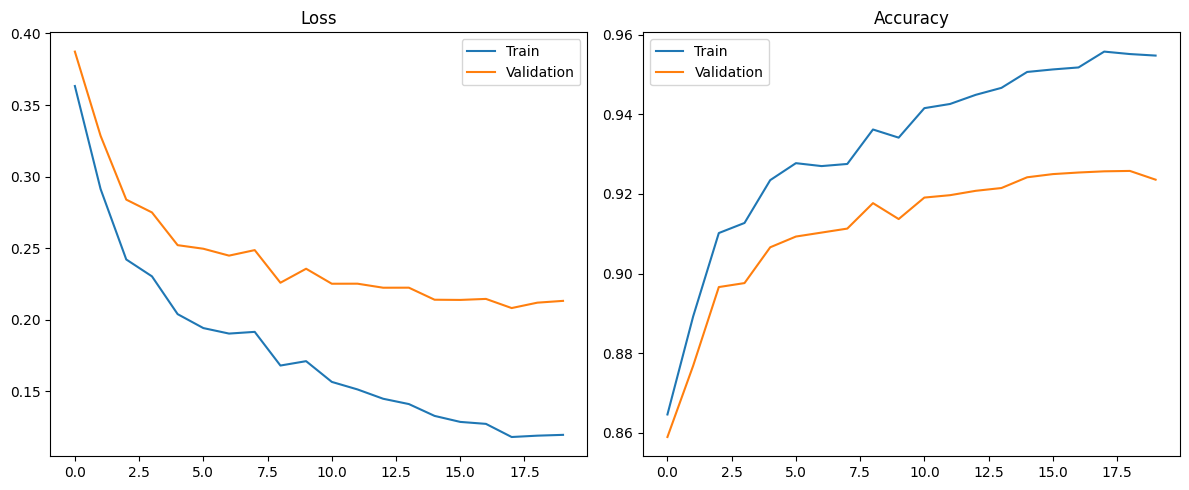

In [15]:
from module.utils import plot_fit_result

plot_fit_result(*result)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
save_path = os.path.join(MODEL_SAVE_PATH, "fmnist_cnn_model.pt")
target_path = "/content/drive/MyDrive/07_deeplearning/models/fmnist_cnn_model.pt"

In [18]:
import shutil

shutil.copyfile(save_path, target_path)

'/content/drive/MyDrive/07_deeplearning/models/fmnist_cnn_model.pt'

## Train